In [1]:
# my own libraries
import sys
sys.path.insert(0, './')

import prepare_data
import inspect_results as inspect

# for baselines
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pickle

# for the deep learning model
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, losses, activations
from tensorflow.keras.callbacks import EarlyStopping

# utils
import joblib
import sys
import numpy as np
import pandas as pd
np.random.seed(7)

# for visualization
import matplotlib.pyplot as plt

# CMAPSS DATA
Source: https://data.nasa.gov/widgets/xaut-bemq

**An Overview of the Dataset**

C-MAPSS stands for 'Commercial Modular Aero-Propulsion System Simulation' and it is a tool for the simulation of realistic large commercial turbofan engine data. 

The data provided is from a high fidelity system level engine simulation designed to simulate nominal and fault engine degradation over a series of flights (each datapoint). 
The three flight conditions (called operational conditions) are arranged to cover a typical ascent from sea level to 35K ft and descent back down to sea level. The fault was injected at a given time in one of the flights and persists throughout the remaining flights, effectively increasing the age of the engine. The intent is to identify which flight and when in the flight the fault occurred.

**Data Challenge**

This dataset is provided for the PHM08 challenge, where they aim to predict the remaining useful life of the flight engines (a regression task). 
For the simplicity of my project, I transfer this regression task into a binary classification task.

For this purpose, I use the existing preprocessing approaches for predicting the RUL and transferring the RULs into binary classes, representing the engines' healthy and unhealthy states. The healthy state is for when the RUL of the engine is a constant number, and the unhealthy states are when the RUL starts to degrade linearly.
I also use only one time series (the sensor measurement 12), which measures the engine's fan speed. I chose this time series because a simple linear regression from my previous work had shown that this parameter had the highest influence on the prediction results.

**The winners of the Challenge**

The papers I read and used for my preprocessing parameters are the following:
* Heimes, F.O., “Recurrent neural networks for remaining useful life estimation”, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.
* Tianyi Wang, Jianbo Yu, Siegel, D., Lee, J., “A similarity-based prognostics approach for Remaining Useful Life estimation of engineered systems”, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.
* Peel, L., “Recurrent neural networks for remaining useful life estimation”, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

# Load Data

Succesfully loaded PHM08 data from ../../Datasets/PHM08_Challenge_Data/train.txt
Succesfully calculated the CTFs (Cycles to Failure).
Succesfully calculated the RULs (Remaining Useful Lives).
Succesfully calculated the Heath States.


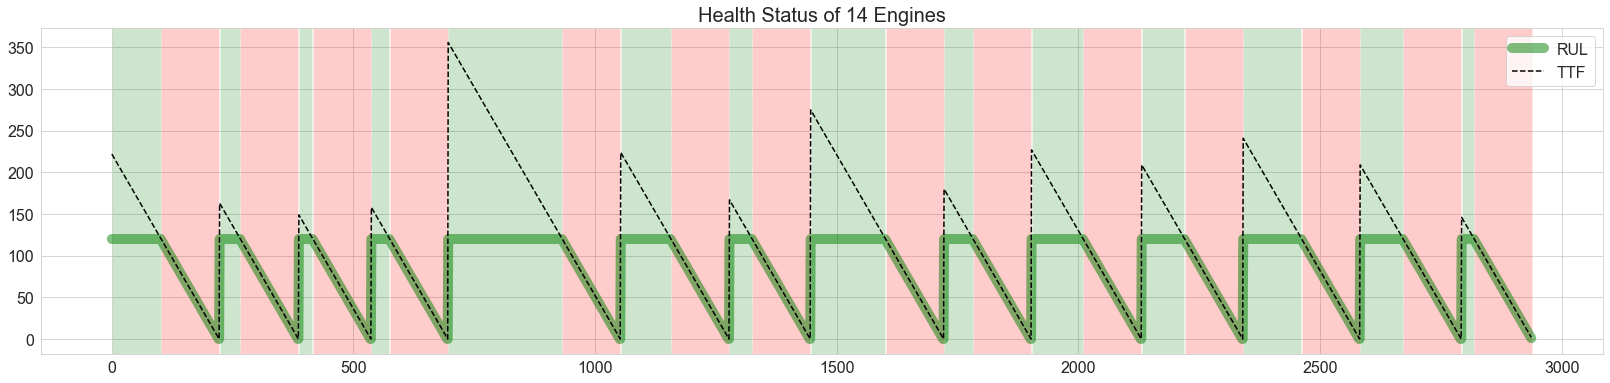

In [2]:
cmapss = prepare_data.CMAPSS()

"""dev model should be fisrt true, 
and only if we decide to start labeling 
the test set provided by NASA we should set it to FALSE"""
dev_mode = True 

path = "../../Datasets/PHM08_Challenge_Data/train.txt"

dev_data = cmapss.load_data(path)

# Based on the winners' papers and confirmed by my exploratory 
# analysis, the operational settings can be clustered into six
# groups. The hint is also mentioned by the challenge organizers
# that these operational modes are correlated with the injected
# faults. Therefore, cluster_operational_settings gives the 
# operational mode of each flight data.
dev_data = cmapss.cluster_operational_settings(dev_data,
                                               dev_mode)


# Now, I calculate the Time (Cycle) to Failure of each engine.
# Again, based on the documentation of the dataset, each engine's 
# life duration starts from a healthy state and ends with the 
# breakdown (Run to Failure data). I do this by simply reversing
# the values of column "cycle" for each "unit" (engines).
dev_data = cmapss.calculate_TTF(dev_data)

# Here, I now use the TTF labels and apply a piecewise linear 
# function to create the label for the Remaining Useful Life (RUL) 
# of each engine. For this purpose, I use a maximum life cycle of 
# 120, proposed by the winner of the challenge.
dev_data = cmapss.calculate_continues_healthstate(dev_data)


# Now that I have the RULs of the engines, I can transfer the 
# regression task into a binary classification task. 
# The function below, returns the label 0 for healthy state and 1
# for an unhealthy state
dev_data = cmapss.calculate_descrete_healthstate(dev_data)


# I do a sanity check here and visualize all three labels
# The zic-zac dash-lines are the TTF
# The bold green lines are the RULs
# and the background colors are the binary labels (green for 
# healthy and red for unhealthy)
# the integer 14 is just a number I pass to visualize the labels
# of 14 engines.
cmapss.visualize_healthstatus(dev_data, 14) 

# Preprocess Data
## prepare train set

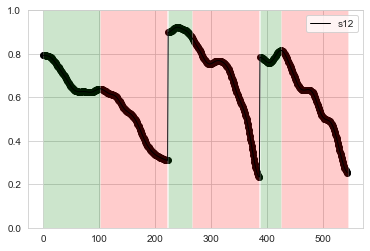

In [3]:
# As I mentioned before, the dataset is a multivariate dataset
# I only use the measurement 12 (fan speed) for a univariate analysis
dev_data = cmapss.get_univariate_cmapss(dev_data, "s12")


# Now, I split the dataset into a train and test
# ensuring that the trainset min and max values of each engine
# and each operational mode is saved for min-max normalizations 
x_train, x_test = cmapss.train_test_split(dev_data)

# I use the trainset min and max values to normalize the datasets
x_train = cmapss.minmax_scale(x_train)


# As it was mentioned in the documentation, the time series is very
# noisy, and therefore, I use a gaussian filter to smooth the data
x_train = cmapss.denoise_sensors(x_train)


# For a sanity check, I visualize the processed data
# of 3 flight engines. Now we see how the engine's health
# degrades over time (stationary time series to a trend)
cmapss.visualize_denoised_sensors(x_train, 3)

## prepare test set

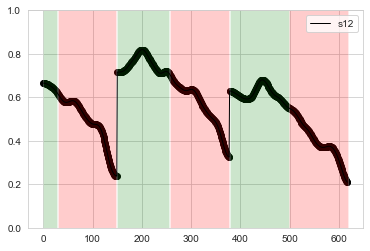

In [4]:
# We apply the same steps and create a processed unseen data
x_test = cmapss.minmax_scale(x_test)
x_test = cmapss.denoise_sensors(x_test)
cmapss.visualize_denoised_sensors(x_test, 3)

## Prepare Input Shape

In [5]:
# Here, I prepare my input data for a time series modeling
# for this, I apply a windowing function, which goes over
# 20 timesteps with a 50% overlap with its previous window
# These two parameters are also tuned.

w_size=20
x_train, y_train, train_engines = cmapss.window_data(x_train, w_size, w_size//2)
x_test, y_test, test_engines = cmapss.window_data(x_test, w_size, w_size//2)

print("Trainset shape: data={}\nTestset shape: data={}".format(
      x_train.shape, x_test.shape))

Trainset shape: data=(3136, 20)
Testset shape: data=(1332, 20)


# Baselines

To compare my black-box model's performance, I create four different baselines.
* Two linear baselines because I believe a linear model can also be used to predict the health states for this data.
* A distance-based model (KNN) because I use the spatial dimensions of my time series to calculate the similarities of the data points for generating factual and counterfactual examples.
* A rule-based model (Decision Tree), because I use a global surrogate tree to understand the decision cuts my black-box model could have also had for its decisions.

## Linear Models 
### Logistic Regression

C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       531
           1       0.84      0.83      0.83       801

    accuracy                           0.80      1332
   macro avg       0.79      0.79      0.79      1332
weighted avg       0.80      0.80      0.80      1332



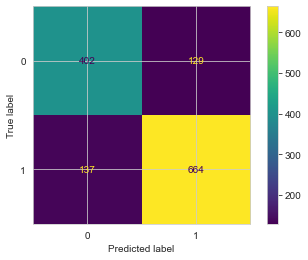

In [6]:
lr = LogisticRegressionCV(cv=10, random_state=7).fit(x_train, y_train)
lr_pred_test = lr.predict(x_test)

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, lr_pred_test)


# save the classifier
with open('LogisticRegressionCV.pkl', 'wb') as fid:
    pickle.dump(lr, fid)
fid.close()

### Ridge Classifier


X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       531
           1       0.83      0.81      0.82       801

    accuracy                           0.79      1332
   macro avg       0.78      0.79      0.78      1332
weighted avg       0.79      0.79      0.79      1332



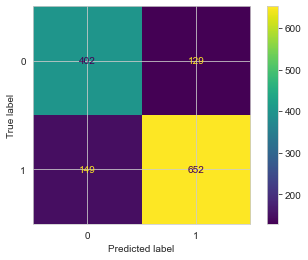

In [7]:
ridge = RidgeClassifierCV(cv=10).fit(x_train, y_train)
ridge_pred_test = ridge.predict(x_test)

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, ridge_pred_test)

# save the classifier
with open('RidgeClassifierCV.pkl', 'wb') as fid:
    pickle.dump(ridge, fid)
fid.close()

## Distance-based model
### K-Nearest Neighbour - on the spatial dimension


X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.76      0.72       531
           1       0.83      0.78      0.80       801

    accuracy                           0.77      1332
   macro avg       0.76      0.77      0.76      1332
weighted avg       0.77      0.77      0.77      1332



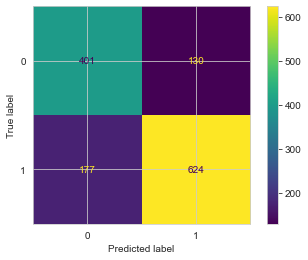

In [8]:
knn = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
knn_pred_test = knn.predict(x_test)

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, knn_pred_test)

# save the classifier
with open('KNeighborsClassifier.pkl', 'wb') as fid:
    pickle.dump(knn, fid)
fid.close()

### K-Nearest Neighbour - on Spatial and Time-dimension



X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.87      0.76       531
           1       0.89      0.72      0.80       801

    accuracy                           0.78      1332
   macro avg       0.78      0.79      0.78      1332
weighted avg       0.80      0.78      0.78      1332



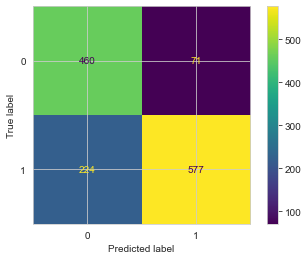

In [9]:
train_DTW_classifier = False
filename = 'knn-dtw.sav'

if train_DTW_classifier:
    knn_true = inspect.KNN_DTW(x_train, y_train)
    print("Successfully classified time series with DTW.")

    #executed in 9h 13m 10s
    knn_true_pred = []
    for i in range(len(x_test)):
        print("{},".format(i),end="")
        knn_true_pred += list(knn_true.predict(x_test[i:i+1]))

    # save the model
    joblib.dump(knn_true, filename)

    # save the predictions
    with open("{}-test-preds.txt".format(
        filename.replace(".sav", "")), "w") as f:
        for p in knn_true_pred:
            f.write(str(p)+"\n")
    f.close()
    
else:
    # Loading scikit-learn model
    #loaded_model = joblib.load(filename)

    # loading the saved predictions
    with open("{}-test-preds.txt".format(
         filename.replace(".sav", "")), "r") as f:
         test_preds = f.read()
    f.close()

    knn_true_pred = []
    for p in test_preds.split("\n"):
        try:
            knn_true_pred.append(float(p))
        except Exception:
            print(p)
            
print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, knn_true_pred)

## Rule-Based Model
### Decision Tree


X_TEST Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       531
           1       0.81      0.82      0.82       801

    accuracy                           0.78      1332
   macro avg       0.77      0.77      0.77      1332
weighted avg       0.78      0.78      0.78      1332



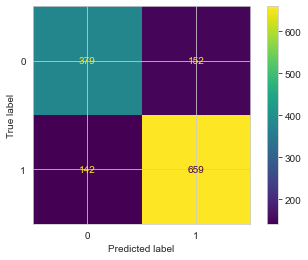

In [10]:
dt = DecisionTreeClassifier(random_state=7,
                            max_depth=5).fit(x_train, y_train)
dt_pred_test = dt.predict(x_test)

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test, dt_pred_test)

with open('DecisionTreeClassifier.pkl', 'wb') as fid:
    pickle.dump(dt, fid)
fid.close()

### Visualize the Tree (See where the decision cuts are)

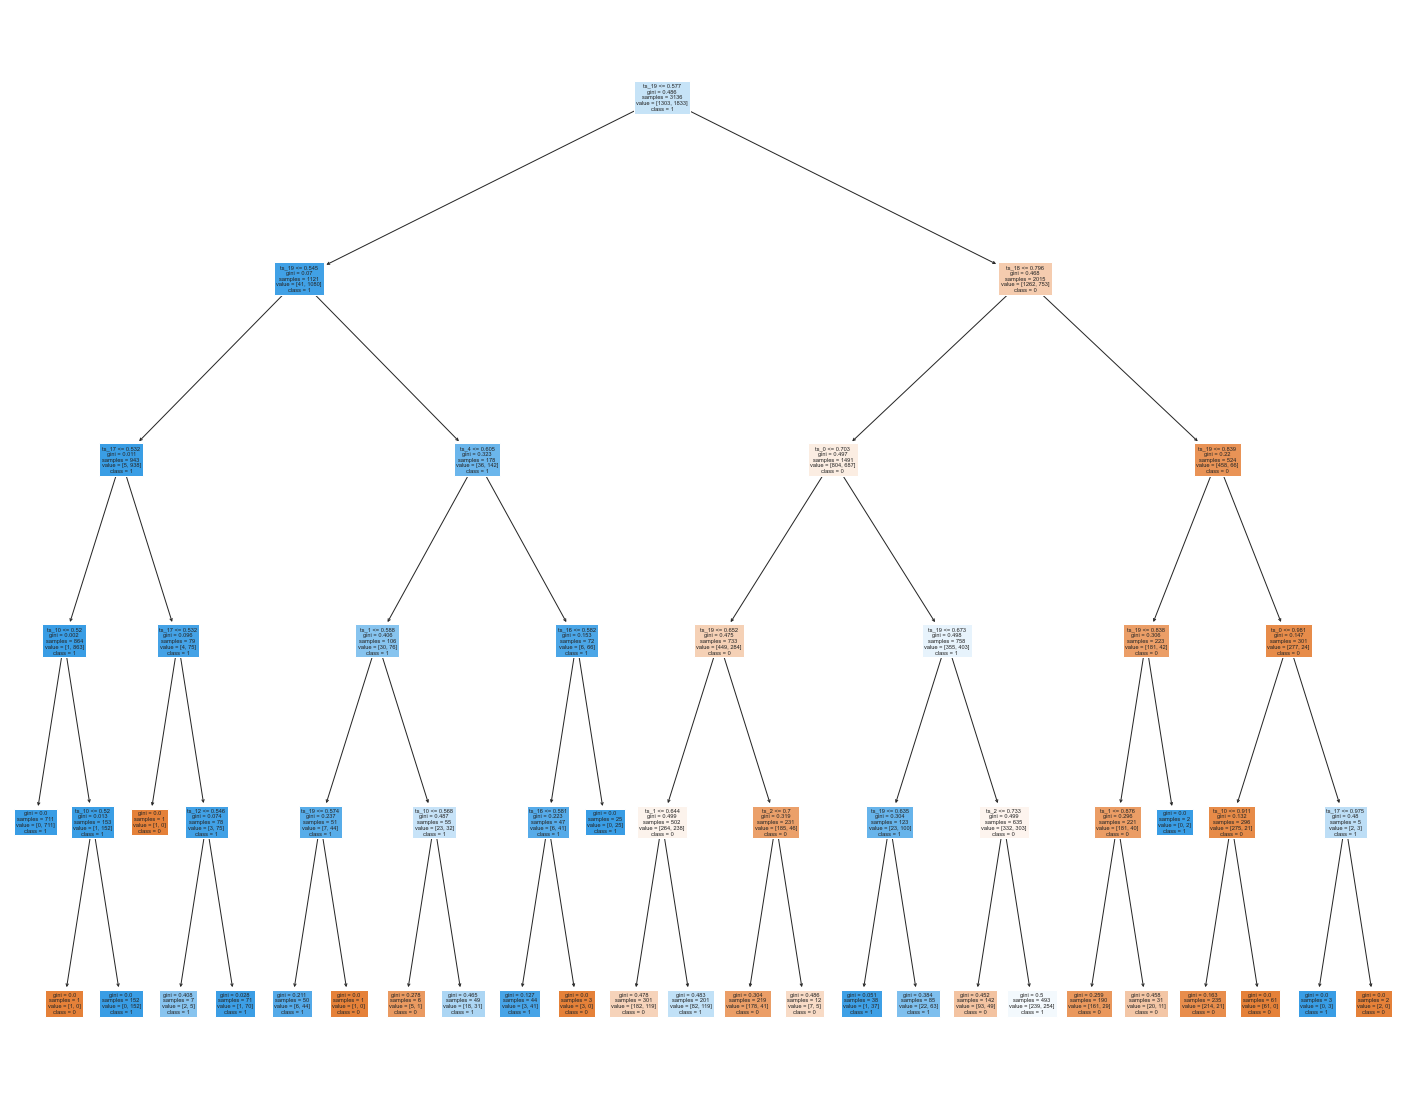

In [11]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=["ts_{}".format(i) # each timestep is a feature
                                  for i in range(x_train.shape[1])],  
                   class_names=["0", "1"], # 0=healthy, 1=unhealthy
                   filled=True)

# Build Deep Learning Model

We choose a sequential model for our binary time series classifier. For this purpose, we build a Long-Short Term Memory (an extention of RNN models).

In [12]:
input_shape = (x_train.shape[1], 1)
print(input_shape)

x_train = np.asarray(x_train, dtype="float")
y_train = np.asarray(y_train, dtype="float")

x_test = np.asarray(x_test, dtype="float")
y_test = np.asarray(y_test, dtype="float")

(20, 1)


In [13]:
### save the datasets
from numpy import savetxt

savetxt('x_train.csv', x_train, delimiter=',')
savetxt('y_train.csv', y_train, delimiter=',')
savetxt('x_test.csv', x_test, delimiter=',')
savetxt('y_test.csv', y_test, delimiter=',')

## Vanilla LSTM

This is the fisrt state of my model: a vanilla LSTM

### Build

source: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [14]:
vanilla_lstm = Sequential()
vanilla_lstm.add(LSTM(20, input_shape=input_shape))
vanilla_lstm.add(Dense(1, activation="sigmoid")) 

vanilla_lstm.compile(loss="binary_crossentropy", optimizer="sgd")
vanilla_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


### Train

In [15]:
vanilla_lstm_history = vanilla_lstm.fit(x_train[:, :, np.newaxis], y_train,
                                        validation_split=0.30,
                                        epochs=20, verbose=1)

Epoch 1/20
69/69 [==============================] - 4s 22ms/step - loss: 0.6931 - val_loss: 0.6726
Epoch 2/20
69/69 [==============================] - 1s 12ms/step - loss: 0.6700 - val_loss: 0.6614
Epoch 3/20
69/69 [==============================] - 1s 11ms/step - loss: 0.6619 - val_loss: 0.6548
Epoch 4/20
69/69 [==============================] - 1s 12ms/step - loss: 0.6567 - val_loss: 0.6490
Epoch 5/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6491 - val_loss: 0.6428
Epoch 6/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6468 - val_loss: 0.6359
Epoch 7/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6372 - val_loss: 0.6280
Epoch 8/20
69/69 [==============================] - 1s 11ms/step - loss: 0.6273 - val_loss: 0.6175
Epoch 9/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6236 - val_loss: 0.6040
Epoch 10/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6049 - val_loss: 0.5872
Epoch 11/

### Evaluation

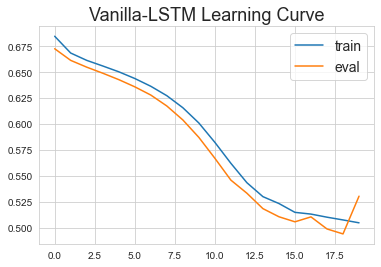

In [16]:
# plot learning curves
plt.title("Vanilla-LSTM Learning Curve", fontsize=18)
plt.plot(vanilla_lstm_history.history['loss'], label='train')
plt.plot(vanilla_lstm_history.history['val_loss'], label='eval')
plt.legend(fontsize=14)


X_TEST Classification Report:

              precision    recall  f1-score   support

         0.0       0.69      0.53      0.60       531
         1.0       0.73      0.84      0.78       801

    accuracy                           0.72      1332
   macro avg       0.71      0.69      0.69      1332
weighted avg       0.71      0.72      0.71      1332



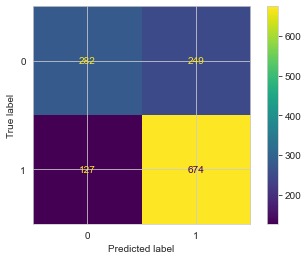

In [17]:
vlstm_pred_test = vanilla_lstm.predict(x_test[:, :, np.newaxis])

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test,
                                   inspect.continues_to_binary(vlstm_pred_test))

## Fine-Tuned LSTM
### Build

In [18]:
lr = 0.01
optimizer = 'adam'
neurons = 64
dropout = 0.25
activation = 'tanh'
loss_function = 'binary_crossentropy'

batchSize = 32
epochs = 500
verbose = 1

opt = None
if optimizer == 'sgd':
    opt = optimizers.SGD(lr=lr, decay=1e-6,
                         momentum=0.9, nesterov=True)
elif optimizer == 'rmsprop':
    opt = optimizers.RMSprop(lr=lr, rho=0.9,
                             epsilon=1e-08, decay=0.01)
elif optimizer == 'adam':
    opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,
                          epsilon=1e-08, decay=0.01)
    
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')


"""Build the model"""
lstm = Sequential()

lstm.add(LSTM(neurons, activation=activation, 
               return_sequences=True,
               input_shape=input_shape))
lstm.add(Dropout(dropout))

# lstm.add(LSTM(neurons, activation=activation, return_sequences=True,))  
# lstm.add(Dropout(dropout))

lstm.add(LSTM(neurons, activation=activation))  
lstm.add(Dropout(dropout))

lstm.add(Dense(1, activation="sigmoid"))          
lstm.compile(loss=loss_function, optimizer=opt)
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Train 

In [19]:
lstm_history = lstm.fit(x_train[:, :, np.newaxis], y_train,
                        validation_split=0.25,
                        callbacks = [earlystop],
                        batch_size=batchSize,
                        epochs=epochs,
                        verbose=verbose)

Epoch 1/500
74/74 [==============================] - 7s 36ms/step - loss: 0.6220 - val_loss: 0.4809
Epoch 2/500
74/74 [==============================] - 2s 23ms/step - loss: 0.5018 - val_loss: 0.4644
Epoch 3/500
74/74 [==============================] - 2s 23ms/step - loss: 0.4726 - val_loss: 0.4792
Epoch 4/500
74/74 [==============================] - 2s 23ms/step - loss: 0.4802 - val_loss: 0.4549
Epoch 5/500
74/74 [==============================] - 2s 24ms/step - loss: 0.4576 - val_loss: 0.4357
Epoch 6/500
74/74 [==============================] - 2s 24ms/step - loss: 0.4522 - val_loss: 0.4389
Epoch 7/500
74/74 [==============================] - 2s 23ms/step - loss: 0.4569 - val_loss: 0.4344
Epoch 8/500
74/74 [==============================] - 2s 23ms/step - loss: 0.4428 - val_loss: 0.4350
Epoch 9/500
74/74 [==============================] - 2s 23ms/step - loss: 0.4437 - val_loss: 0.4407
Epoch 10/500
74/74 [==============================] - 2s 25ms/step - loss: 0.4283 - val_loss: 0.4226

### Evaluation

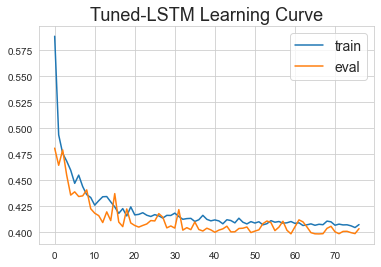

In [20]:
# plot learning curves
plt.title("Tuned-LSTM Learning Curve", fontsize=18)
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='eval')
plt.legend(fontsize=14)


X_TEST Classification Report:

              precision    recall  f1-score   support

         0.0       0.71      0.80      0.76       531
         1.0       0.86      0.79      0.82       801

    accuracy                           0.79      1332
   macro avg       0.79      0.79      0.79      1332
weighted avg       0.80      0.79      0.79      1332



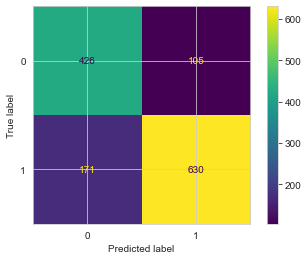

In [21]:
lstm_pred_test = lstm.predict(x_test[:, :, np.newaxis])

print('\nX_TEST Classification Report:\n')
inspect.plot_classification_report(y_test,
                                   inspect.continues_to_binary(lstm_pred_test))

### Save/Load model

In [22]:
lstm.save("LSTM")

INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


In [23]:
load_model = False
save_model = True


if load_model:
    # make sure that save_model is False
    save_model = False

In [24]:
from keras.models import model_from_json
from keras.models import model_from_yaml

if load_model:
    from keras.models import load_model
    yaml_file = open('lstm.yaml', 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    loaded_model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    loaded_model.load_weights("lstm.h5")
    
else:
    if save_model:
        # serialize model to YAML
        model_yaml = lstm.to_yaml()
        with open("lstm.yaml", "w") as yaml_file:
            yaml_file.write(model_yaml)
        # serialize weights to HDF5
        lstm.save_weights("lstm.h5")
        print("Saved model to disk")

Using TensorFlow backend.


Saved model to disk


# Model Inspection

## Where does model fail on the unseen data?


Here, I would like to see if there is a pattern in the failed predictions. 
For this, I cluster the test data within each of its classes. Then I look to see which clusters have failed predictions and whether the samples with failed predictions are close to the predicted class and further from their true class.

### Clustered test set (by their true labels)

In [25]:
labels_are_predicted = False
test_cluster = inspect.get_clustered_data(x_test, y_test, labels_are_predicted)

After many hours of parameter tuning, I noticed that my model is not getting higher accuracy and F1-score. So I look at the data, both train, and test, to see if I can find difficult clusters to classify. And yes, there is an overlap between the healthy and unhealthy data. 

My assumption here is that the boundary of the healthy and unhealthy state for each engine (based on the piecewise linear regression) is weakly defined and needs relabling. But since I am not an expert, it wuld be nice to have an opinion of an expert. 

_________________________________________________________________________________________________
NOTE: the two axis of the following plots are always the first timestep over the last timestep of each sequence.

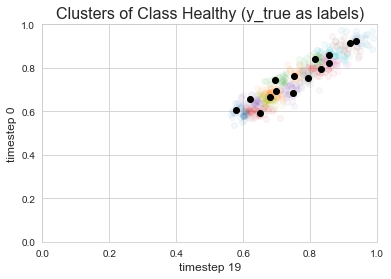

In [26]:
inspect.visualize_clusters(test_cluster["healthy_data"],
                           test_cluster["healthy_clusters"],
                           "Clusters of Class Healthy (y_true as labels)")

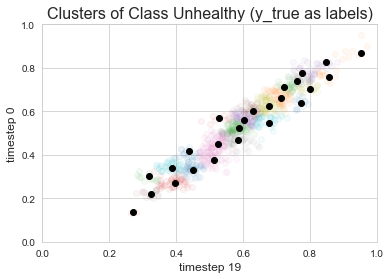

In [27]:
inspect.visualize_clusters(test_cluster["unhealthy_data"],
                           test_cluster["unhealthy_clusters"],
                           "Clusters of Class Unhealthy (y_true as labels)")

### Clustered test set (by their predicted labels)


Here, I would like to look at the model's decision boundary, and I see that the boundary for unhealthy states is much lower than the ones we see from the actual labels.

In [28]:
labels_are_predicted = True
test_cluster = inspect.get_clustered_data(x_test,
                                          inspect.continues_to_binary(lstm_pred_test),
                                          labels_are_predicted)

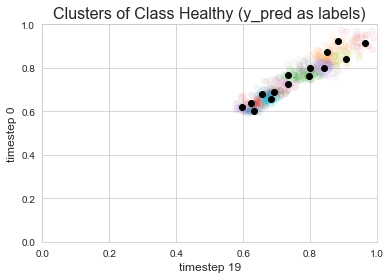

In [29]:
inspect.visualize_clusters(test_cluster["healthy_data"],
                           test_cluster["healthy_clusters"],
                           "Clusters of Class Healthy (y_pred as labels)")

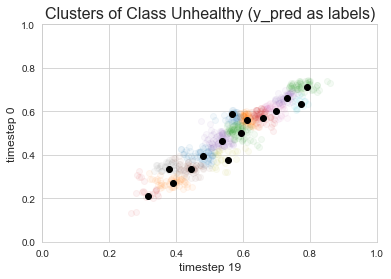

In [30]:
inspect.visualize_clusters(test_cluster["unhealthy_data"],
                           test_cluster["unhealthy_clusters"],
                           "Clusters of Class Unhealthy (y_pred as labels)")

In [31]:
# Now that I separately looked at the healthy and unhealthy data, 
# I generate a dataframe, which contains both healthy and unhealthy clusters
# clustered based on their predicted labels and the prediction confidence
# to compare the results with the actual labels
test_cluster_df = inspect.get_clustered_df(x_test, y_test, lstm_pred_test)

### Plot all the data

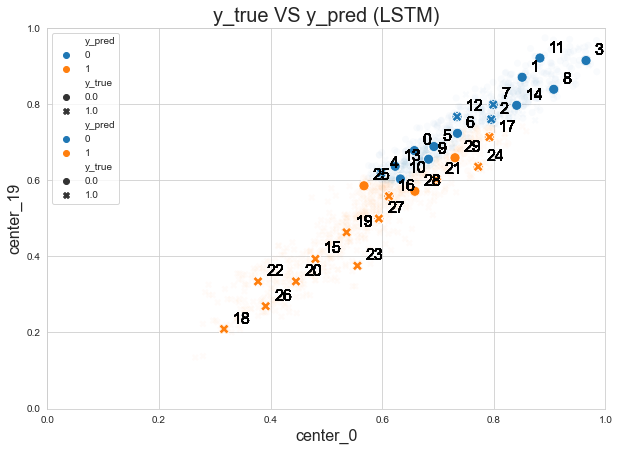

In [32]:
inspect.visualize_predictions(test_cluster_df, "LSTM")

### Plot Failed predictions

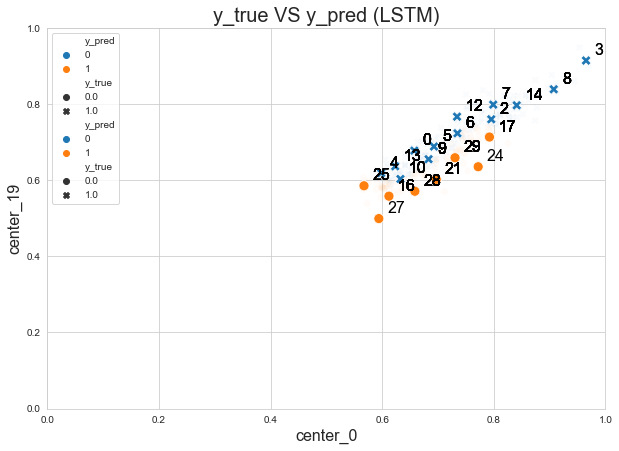

In [33]:
inspect.visualize_predictions(test_cluster_df[
    test_cluster_df.y_true != test_cluster_df.y_pred],
                      "LSTM")

### Plot False Positives

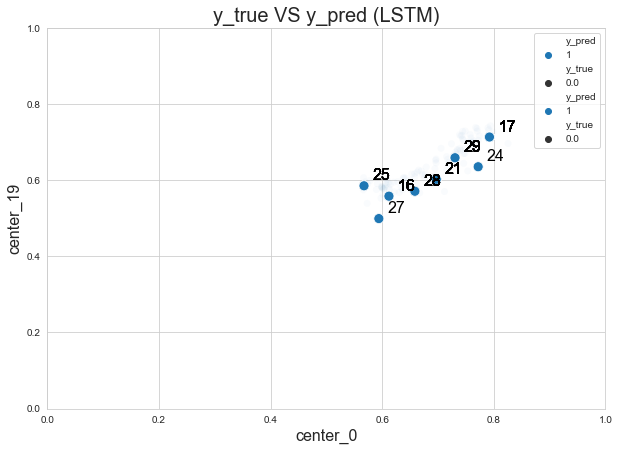

In [34]:
inspect.visualize_predictions(test_cluster_df[
    (test_cluster_df.y_true==0) & (test_cluster_df.y_pred==1)],
                      "LSTM")

### Plot False Negatives

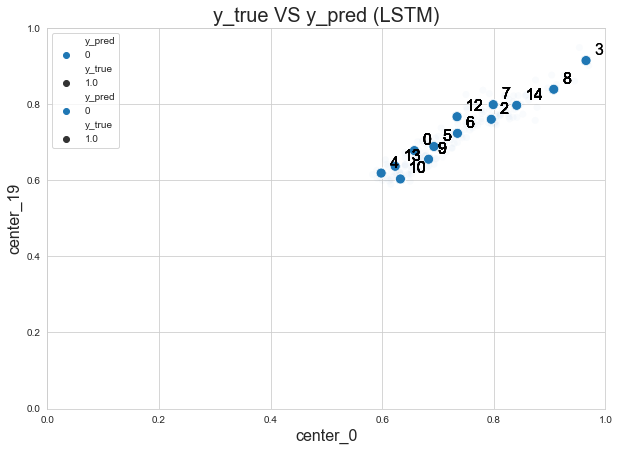

In [35]:
inspect.visualize_predictions(test_cluster_df[
    (test_cluster_df.y_true==1) & (test_cluster_df.y_pred==0)],
                      "LSTM")

## Where does model fail on the train data?


Here, I would like to see if there is a pattern in the failed predictions of what the model was learning. Like the test set, I cluster the train data within each of its classes. Then I look to see which clusters have failed predictions and whether the samples with failed predictions are close to the predicted class and further from their true class.

### Clustered train set (by their true labels)

In [36]:
labels_are_predicted = False
train_cluster = inspect.get_clustered_data(x_train, y_train, labels_are_predicted)

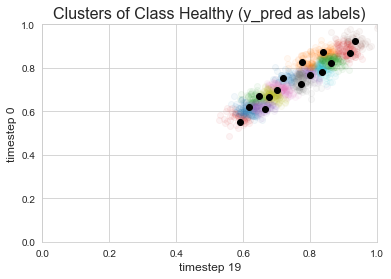

In [37]:
inspect.visualize_clusters(train_cluster["healthy_data"],
                           train_cluster["healthy_clusters"],
                           "Clusters of Class Healthy (y_pred as labels)")

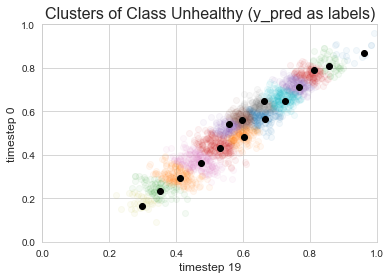

In [38]:
inspect.visualize_clusters(train_cluster["unhealthy_data"],
                           train_cluster["unhealthy_clusters"],
                           "Clusters of Class Unhealthy (y_pred as labels)")

### Clustered train set (by their predicted labels)


X_TRAIN Classification Report:

              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76      1303
         1.0       0.84      0.78      0.81      1833

    accuracy                           0.79      3136
   macro avg       0.78      0.79      0.78      3136
weighted avg       0.79      0.79      0.79      3136



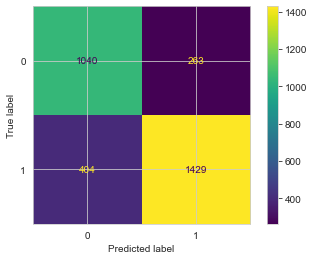

In [39]:
lstm_pred_train = lstm.predict(x_train[:, :, np.newaxis])

print('\nX_TRAIN Classification Report:\n')
inspect.plot_classification_report(y_train,
                                   inspect.continues_to_binary(lstm_pred_train))

In [40]:
# Here, I create clusters for the trainset, but this time with the predicted labels
labels_are_predicted = True

train_cluster = inspect.get_clustered_data(x_train,
                                           inspect.continues_to_binary(lstm_pred_train),
                                           labels_are_predicted)

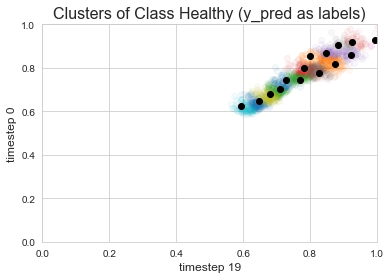

In [41]:
inspect.visualize_clusters(train_cluster["healthy_data"],
                           train_cluster["healthy_clusters"],
                           "Clusters of Class Healthy (y_pred as labels)")

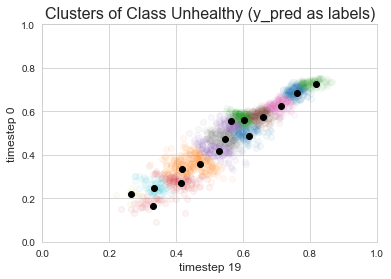

In [42]:
inspect.visualize_clusters(train_cluster["unhealthy_data"],
                           train_cluster["unhealthy_clusters"],
                           "Clusters of Class Unhealthy (y_pred as labels)")

In [43]:
train_cluster_df = inspect.get_clustered_df(x_train, y_train, lstm_pred_train)

### Plot all the data

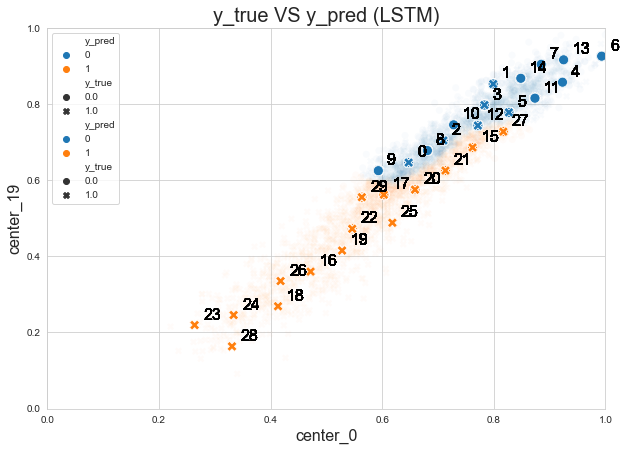

In [44]:
inspect.visualize_predictions(train_cluster_df, "LSTM")

### Plot Failed Predictions

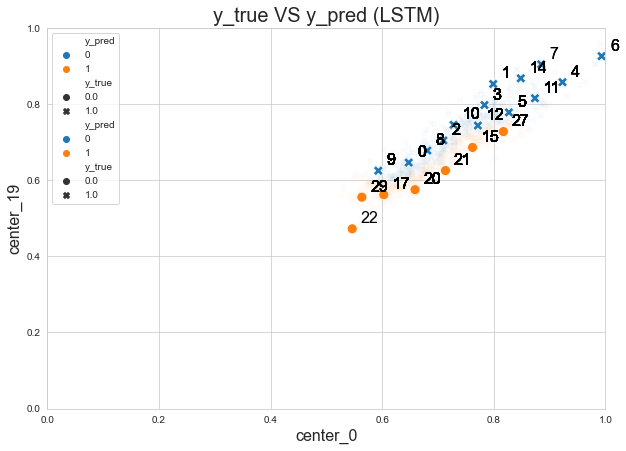

In [45]:
inspect.visualize_predictions(train_cluster_df[
    train_cluster_df.y_true != train_cluster_df.y_pred],
                      "LSTM")

### Plot False Positives

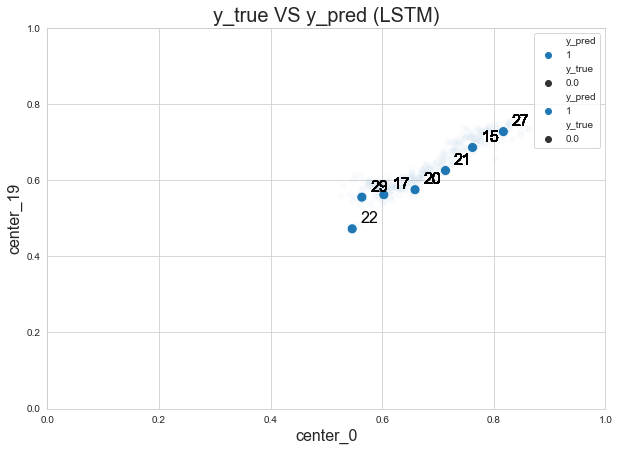

In [46]:
inspect.visualize_predictions(train_cluster_df[
    (train_cluster_df.y_true==0) & (train_cluster_df.y_pred==1)],
                      "LSTM")

### Plot False Negatives

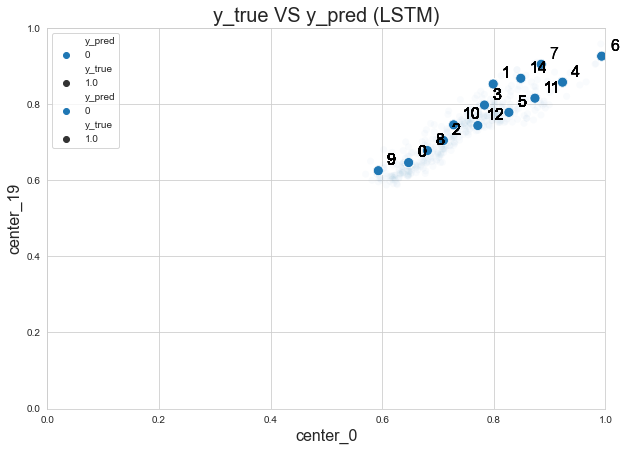

In [47]:
inspect.visualize_predictions(train_cluster_df[
    (train_cluster_df.y_true==1) & (train_cluster_df.y_pred==0)],
                      "LSTM")

# Explainability


In this section, I would like to:

1. Understand the model's prediction by looking at the factual and counterfactual examples. My idea is to pick these examples by looking at the closest correctly predicted samples.
2. Train a surrogate model to understand the highly influential time series characteristics on the model decision. 
3. Using the decision cuts of the surrogate model, I would like to understand the influence of the parameters.


## Extracting Factual and Counterfactual Examples

In [48]:
import explainability as explainer

# select a sample from the test set to get the explanations
# or the train set, depending on what data we pass on to the function
test_df = explainer.get_predictions_as_df(x_test, y_test, lstm_pred_test)
test_df["unit"] = test_engines
test_df.to_csv("test_df.csv", sep=',', index=False)

train_cluster_df["unit"] = train_engines
train_cluster_df.to_csv("train_cluster_df.csv", sep=',', index=False)

with open('train_cluster.pkl', 'wb') as f:
    pickle.dump(train_cluster, f)
f.close()

# Here, I see that the model correctly predicted this sample as healthy.
# However, just by looking at the plot below, I see that the sample is
# closer to its counterfactual (un healthy) cluster.
# But I also see that the model had not very high confidence
selected_sample = test_df.iloc[0]
#explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


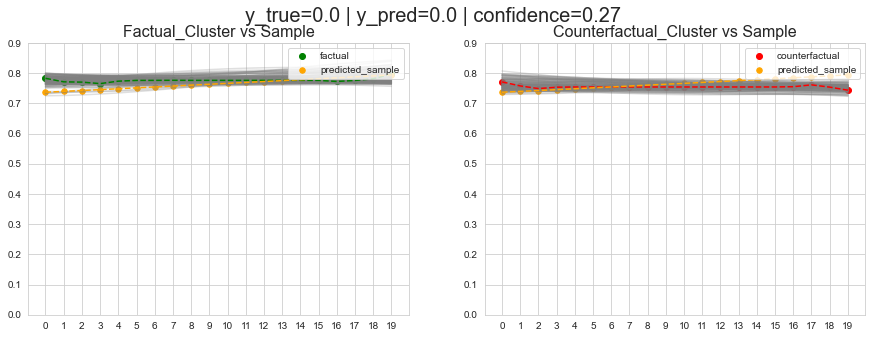

In [49]:
# Here, it makes more sense because I see that the sample
# is closer to the healthy cluster and the model confidence
# is also higher
# By the way, the confidence here means the sigmoid output
# so the closer the value to 0, the better for class healthy
# The closer the value to 1, the better for class 1.

selected_sample = test_df.iloc[16]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


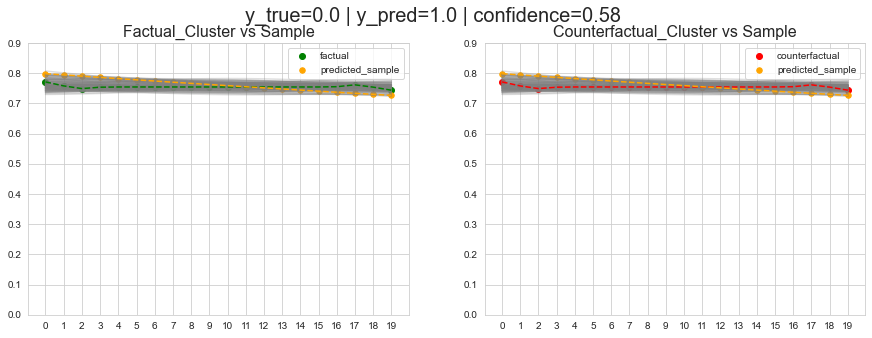

In [50]:
# This is a False Positive example, and I see that the sample
# is indeed closer to its factual (unhealthy) cluster than the
# counterfactual (healthy cluster)

selected_sample = test_df.iloc[20]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


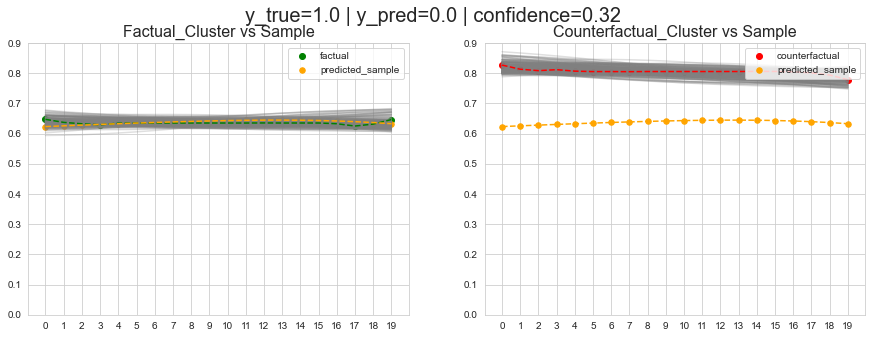

In [51]:
# Now, let us look at the False Negative. Here, again
# looking at the distance does not make sense. Because the sample 
# is closer to its counterfactual cluster (healthy)
# But, when looking at the behavior of the sequence over time,
# I see that the sequence is actually similar to the factual cluster (unhealthy)

selected_sample = test_df.iloc[1245]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
C:\Users\jalalia\AppData\Local\Continuum\anaconda2\envs\tensorflow-py3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


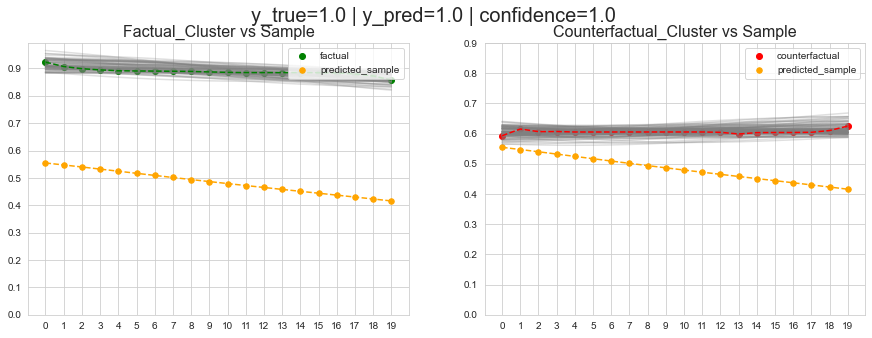

In [52]:
# And finally, a True Positive sample. Again, I see that the spatial
# distance of the sequence is closer to its counterfactual cluster. But 
# looking at the temporal changes, I see that the sequence is actually
# similar to its factual cluster (unhealthy).

selected_sample = test_df.iloc[168]
explainer.get_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

## Global Surrogate Explanations 
**of Human Interpretable Time Series Characteristics**



This section extracts some human-interpretable time series characteristics such as frequency domain features (e.g., frequency) and time-domain features (e.g., mean of amplitude, standard deviation, pitch, and min values).
Afterward, we train a global surrogate model on the extracted features. 

Our assumption here is that: the complex LSTM has already extracted these features from the raw data. Since we use the LSTM predictions to train our surrogate decision tree, we can compare these two models, and the tree could help us understand the decisions made by LSTMs and the responsible time series features.

### Extract features

In [53]:
dev_features = explainer.extract_time_series_features(dev_data, "s12", w_size)

ts_features_train, ts_features_test, feature_names = dev_features
print(ts_features_train.shape, ts_features_test.shape)

(3136, 100) (1332, 100)


### Train Surrogate Tree


X_Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       597
           1       0.96      0.96      0.96       735

    accuracy                           0.96      1332
   macro avg       0.96      0.96      0.96      1332
weighted avg       0.96      0.96      0.96      1332



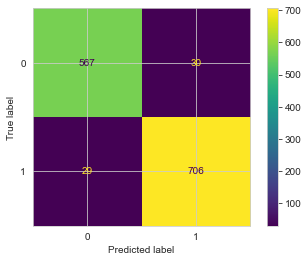

In [54]:
from sklearn.tree import DecisionTreeClassifier


surrogate_dt = DecisionTreeClassifier(random_state=7)
surrogate_dt.fit(ts_features_train,
                 inspect.continues_to_binary(lstm_pred_train))

surrogate_dt_train_preds = surrogate_dt.predict(ts_features_train)

surrogate_dt_test_preds = surrogate_dt.predict(ts_features_test)
print('\nX_Classification Report:\n')
inspect.plot_classification_report(inspect.continues_to_binary(lstm_pred_test),
                                   surrogate_dt_test_preds)

### Get the most influential features

,importance
mean_19,72.067642
fft_12,13.236966
mean_0,2.835247
mean_17,1.313725
std_17,1.026594
fft_18,0.845043
min_9,0.831069
std_7,0.724897
fft_1,0.679178
std_16,0.584952


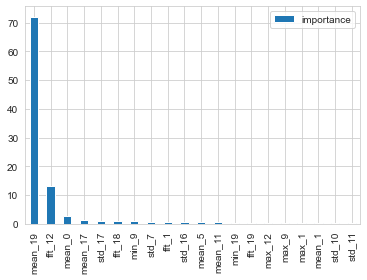

In [55]:
importance = surrogate_dt.feature_importances_
# summarize feature importance
f_imp = pd.DataFrame(importance, columns=["importance"])
f_imp.index = feature_names
f_imp["importance"] = f_imp.importance.values * 100

f_imp=f_imp.sort_values(by=['importance'], ascending=False)
display(f_imp.head(10))
# plot feature importance

f_imp[:20].plot(kind="bar")
plt.show()

### Visualize the decision cuts

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(surrogate_dt, 
                   feature_names=feature_names,  
                   class_names=["healthy", "unhealthy"],
                   filled=True)

**My Future Work for the Ph.D.:**

I would like to continue further with the idea and work on:

1. The generated local neighborhood is too small. Therefore, I cannot train a stable surrogate model --> I look into the existing time series synthetic data generation to synthetically generate more data in a neighborhood.

2. I would like to work further on the inspection module and look at the failed clusters and the factual and counterfactual clusters vs. a given sample. 

3. The results of step 2 can help me find whether my labeled data is correctly labeled. And if a cluster should be labeled differently, I can provide the visualization to an expert. The expert can accept or reject the recommended label. This moves my approach from a model-centric approach to a data-centric machine learning, in which I can also improve the quality of the data using the explanations.

4. I thik we need more information on the visualizations, like which time steps are responsible? May be I can use normalized agregate lime here? 

5. Video

6. Report

7. I need to add a requirement file

8. Whatch out for the warnings in PyCharm!!

In [56]:
!{sys.executable} -m pip install pipreqs

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=e310d5393202dbe557378214170a8f535f0f6dcb562dd8688c96e5ae553852ba
  Stored in directory: c:\users\jalalia\appdata\local\pip\cache\wheels\3f\2a\fa\4d7a888e69774d5e6e855d190a8a51b357d77cc05eb1c097c9
Successfully built docopt
